In [2]:
## ensure that the right versions of tensorflow and keras are installed. Code may work for tf>=1.14 and keras>=2.3.1 as well

# !pip install tensorflow==1.14
# !pip install tensorflow-gpu==1.14
# !pip install cleverhans
# !pip install keras==2.3.1 

In [3]:
## Author : Sumanth Hegde

import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [4]:
#import necessary libraries
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd

%matplotlib inline
import pylab as pl

from IPython import display

from tensorflow.examples.tutorials.mnist import input_data
import pickle



/home/sumanth/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sumanth/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sumanth/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sumanth/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework

In [5]:
## Fix seed to improve reproducibility
tf.set_random_seed(1234)
np.random.seed(1331) 

In [6]:
# Download MNIST dataset
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

num_classes= 10 # number of classes

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16046982148898070153
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5859014327084089664
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10988499764
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18320154112736665397
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7649517279522501242
physical_device_desc: "device: XLA_GPU device"
]


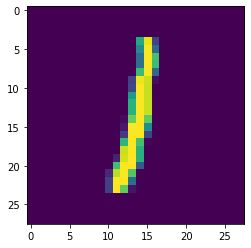

In [8]:
digit_one = mnist.train.images[4].copy()
plt.imshow(digit_one.reshape(28,28)) 
plt.show()

In [9]:
# define some utility functions
def var(name, shape, init=None):
    if init is None:
        init = tf.truncated_normal_initializer(stddev=(2/shape[0])**0.5)
    return tf.get_variable(name=name, shape=shape, dtype=tf.float32,
                          initializer=init)

def conv(Xin, f, strides=[1, 1, 1, 1], padding='SAME'):
    return tf.nn.conv2d(Xin, f, strides, padding)

def max_pool(Xin, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'):
    return tf.nn.max_pool(Xin, ksize, strides, padding)

def rotate_img(x, deg):
    import scipy.ndimage as nd
    return nd.rotate(x.reshape(28,28),deg,reshape=False).ravel()

In [10]:
# Create a LeNet network with softmax cross entropy loss function
def LeNet_softmax(lmb=0.005): 
    g = tf.Graph()
    with g.as_default():
        X = tf.placeholder(shape=[None,28*28], dtype=tf.float32)
        Y = tf.placeholder(shape=[None,10], dtype=tf.float32)
        keep_prob = tf.placeholder(dtype=tf.float32)
        
        # first hidden layer - conv
        W1 = var('W1', [5,5,1,20])
        b1 = var('b1', [20])
        # print('!!!!COmputing out1 now!!!!')
        out1 = max_pool(tf.nn.relu(conv(tf.reshape(X, [-1, 28,28, 1]), 
                                        W1, strides=[1, 1, 1, 1]) + b1))
        # second hidden layer - conv
        W2 = var('W2', [5,5,20,50])
        b2 = var('b2', [50])
        out2 = max_pool(tf.nn.relu(conv(out1, W2, strides=[1, 1, 1, 1]) + b2))
        # flatten the output
        Xflat = tf.contrib.layers.flatten(out2)
        # third hidden layer - fully connected
        W3 = var('W3', [Xflat.get_shape()[1].value, 500])
        b3 = var('b3', [500]) 
        out3 = tf.nn.relu(tf.matmul(Xflat, W3) + b3)
#         out3 = tf.nn.dropout(out3, keep_prob=keep_prob)
        #output layer
        W4 = var('W4', [500,10])
        b4 = var('b4',[10])
        logits = tf.matmul(out3, W4) + b4
        
        prob = tf.nn.softmax(logits=logits) 
        
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
        l2_loss = (tf.nn.l2_loss(W3)+tf.nn.l2_loss(W4)) * lmb
        
        step = tf.train.AdamOptimizer().minimize(loss + l2_loss)
        
        # Calculate accuracy
        pred = tf.argmax(logits, 1)
        truth = tf.argmax(Y, 1)
        acc = tf.reduce_mean(tf.cast(tf.equal(pred, truth), tf.float32))
        
        return g, step, X, Y, keep_prob, prob, acc, loss, logits

In [11]:
# get the LeNet network
g1, step1, X1, Y1, keep_prob1, prob1, acc1, loss1, logits1 = LeNet_softmax()

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [12]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess1 = tf.Session(graph=g1, config=config)
with g1.as_default(): 11
    sess1.run(tf.global_variables_initializer())

In [13]:
bsize = 1000 #batch size
n_batches = mnist.train.num_examples // bsize
for epoch in range(50):   
    for i in range(n_batches):
        data, label = mnist.train.next_batch(bsize)
        feed_dict={X1:data, Y1:label, keep_prob1:.5}
        sess1.run(step1,feed_dict)
        print('epoch %d - %d%% '% (epoch+1, (100*(i+1))//n_batches), end='\r' if i<n_batches-1 else '')
        
    train_acc = sess1.run(acc1, feed_dict={X1:mnist.train.images,Y1:mnist.train.labels,keep_prob1:1.})
    test_acc = sess1.run(acc1, feed_dict={X1:mnist.test.images,Y1:mnist.test.labels,keep_prob1:1.})
    
    print('training accuracy: %2.4f \t testing accuracy: %2.4f' % (train_acc, test_acc))

epoch 1 - 100% training accuracy: 0.9195 	 testing accuracy: 0.9269
epoch 2 - 100% training accuracy: 0.9581 	 testing accuracy: 0.9571
epoch 3 - 100% training accuracy: 0.9705 	 testing accuracy: 0.9695
epoch 4 - 100% training accuracy: 0.9776 	 testing accuracy: 0.9753
epoch 5 - 100% training accuracy: 0.9827 	 testing accuracy: 0.9774
epoch 6 - 100% training accuracy: 0.9839 	 testing accuracy: 0.9797
epoch 7 - 100% training accuracy: 0.9859 	 testing accuracy: 0.9783
epoch 8 - 100% training accuracy: 0.9869 	 testing accuracy: 0.9809
epoch 9 - 100% training accuracy: 0.9845 	 testing accuracy: 0.9778
epoch 10 - 100% training accuracy: 0.9883 	 testing accuracy: 0.9801
epoch 11 - 100% training accuracy: 0.9911 	 testing accuracy: 0.9829
epoch 12 - 100% training accuracy: 0.9923 	 testing accuracy: 0.9837
epoch 13 - 100% training accuracy: 0.9921 	 testing accuracy: 0.9817
epoch 14 - 100% training accuracy: 0.9914 	 testing accuracy: 0.9811
epoch 15 - 100% training accuracy: 0.9951 	

## Adversarial attacks

The *fgm* function below is a modified version of the one available in the cleverhans module (v3.0.1 or higher) . Currently, cleverhans does not support evaluation of ensemble models since the final output is required to be a logits. Hence, all models have been evaluated with the probabilities. 

In [14]:
import keras.backend as K
from utilities import fgm

def entropy(X: tf.Tensor) -> tf.Tensor:
    return K.sum(- X * K.log(K.clip(X, 1e-6, 1)), axis=-1)


loss_ce = tf.keras.losses.categorical_crossentropy

with g1.as_default():      
    ent1 = entropy(prob1)
test_accs = []
entropies = []
for eps in np.linspace(0,1,11):
    with g1.as_default():
        x_adv = fgm(X1, prob1, eps=eps, clip_min=None, clip_max=None, loss_fn = loss_ce)

    x_ = sess1.run(x_adv,feed_dict={X1:mnist.test.images, keep_prob1: 1.})
    
    x_ = x_/np.max(x_,1,keepdims=True) # normalize as a pre processing step
    
    prob_adv, test_acc, ent_adv = sess1.run([prob1, acc1, ent1], feed_dict={X1:x_,Y1:mnist.test.labels,keep_prob1:1.})
    test_accs.append(test_acc)
    mean_ent = np.mean(ent_adv)
    entropies.append(mean_ent)
    print('Accuracy : %2.4f Mean entropy : %2.4f for eps : %.2f' % (test_acc, mean_ent, eps))


Instructions for updating:
Use `tf.cast` instead.


Using TensorFlow backend.


Accuracy : 0.9814 Mean entropy : 0.0401 for eps : 0.00
Accuracy : 0.3468 Mean entropy : 0.3560 for eps : 0.10
Accuracy : 0.1142 Mean entropy : 0.3031 for eps : 0.20
Accuracy : 0.0794 Mean entropy : 0.3174 for eps : 0.30
Accuracy : 0.0682 Mean entropy : 0.3337 for eps : 0.40
Accuracy : 0.0622 Mean entropy : 0.3437 for eps : 0.50
Accuracy : 0.0583 Mean entropy : 0.3507 for eps : 0.60
Accuracy : 0.0568 Mean entropy : 0.3515 for eps : 0.70
Accuracy : 0.0552 Mean entropy : 0.3483 for eps : 0.80
Accuracy : 0.0542 Mean entropy : 0.3432 for eps : 0.90
Accuracy : 0.0535 Mean entropy : 0.3383 for eps : 1.00


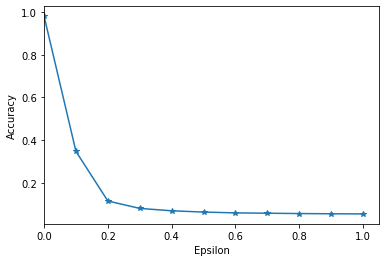

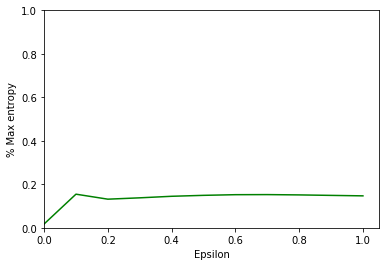

In [15]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0,1,11),test_accs,'-*')
plt.xlabel('Epsilon')
plt.xlim(left=0)
plt.ylabel('Accuracy')
plt.show()
plt.plot(np.linspace(0,1,11),np.array(entropies)/np.log(10),'g')
plt.xlabel('Epsilon')
plt.ylabel('% Max entropy')
plt.xlim(left=0)
plt.ylim(0,1)
plt.show()

In [16]:
## save results in the results directory
if not os.path.exists('./results/'):
    os.mkdir('./results/')
    
with open('./results/accuracies_l2.pkl','wb') as f:
    pickle.dump(test_accs,f)
with open('./results/entropies_l2.pkl','wb') as f:
    pickle.dump(entropies,f)

## EDL 


In [17]:
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)

## Define the loss function


In [18]:
num_classes = 10

In [19]:
def KL(alpha):
    beta=tf.constant(np.ones((1,num_classes)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keep_dims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keep_dims=True)
    lnB = tf.lgamma(S_alpha) - tf.reduce_sum(tf.lgamma(alpha),axis=1,keep_dims=True)
    lnB_uni = tf.reduce_sum(tf.lgamma(beta),axis=1,keep_dims=True) - tf.lgamma(S_beta)
    
    dg0 = tf.digamma(S_alpha)
    dg1 = tf.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keep_dims=True) + lnB + lnB_uni
    return kl

def mse_loss(p, alpha, global_step, annealing_step): 
    S = tf.reduce_sum(alpha, axis=1, keep_dims=True) 
    E = alpha - 1
    m = alpha / S
    
    A = tf.reduce_sum((p-m)**2, axis=1, keep_dims=True) 
    B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keep_dims=True) 
    
    annealing_coef = tf.minimum(1.0,tf.cast(global_step/annealing_step,tf.float32))
    
    alp = E*(1-p) + 1 
    C =  annealing_coef * KL(alp)
    return (A + B) + C

In [20]:
# train LeNet network with expected mean square error loss
def LeNet_EDL(logits2evidence=relu_evidence,loss_function=mse_loss, lmb=0.005):
    g = tf.Graph()
    with g.as_default():
        X = tf.placeholder(shape=[None,28*28], dtype=tf.float32)
        Y = tf.placeholder(shape=[None,10], dtype=tf.float32)
        keep_prob = tf.placeholder(dtype=tf.float32)
        global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
        annealing_step = tf.placeholder(dtype=tf.int32) 
    
        # first hidden layer - conv
        W1 = var('W1', [5,5,1,20])
        b1 = var('b1', [20])
        out1 = max_pool(tf.nn.relu(conv(tf.reshape(X, [-1, 28,28, 1]), 
                                        W1, strides=[1, 1, 1, 1]) + b1))
        # second hidden layer - conv
        W2 = var('W2', [5,5,20,50])
        b2 = var('b2', [50])
        out2 = max_pool(tf.nn.relu(conv(out1, W2, strides=[1, 1, 1, 1]) + b2))
        # flatten the output
        Xflat = tf.contrib.layers.flatten(out2)
        # third hidden layer - fully connected
        W3 = var('W3', [Xflat.get_shape()[1].value, 500])
        b3 = var('b3', [500]) 
        out3 = tf.nn.relu(tf.matmul(Xflat, W3) + b3)
        out3 = tf.nn.dropout(out3, keep_prob=keep_prob)
        #output layer
        W4 = var('W4', [500,10])
        b4 = var('b4',[10])
        logits = tf.matmul(out3, W4) + b4
        
        evidence = logits2evidence(logits)
        alpha = evidence + 1
        
        u = num_classes/ tf.reduce_sum(alpha, axis=1, keep_dims=True) #uncertainty
        
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        
        loss = tf.reduce_mean(loss_function(Y, alpha, global_step, annealing_step))
        l2_loss = (tf.nn.l2_loss(W3)+tf.nn.l2_loss(W4)) * lmb
        
        step = tf.train.AdamOptimizer().minimize(loss + l2_loss, global_step=global_step)
        
        # Calculate accuracy
        pred = tf.argmax(logits, 1)
        truth = tf.argmax(Y, 1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        acc = tf.reduce_mean(match)
        
        total_evidence = tf.reduce_sum(evidence,1, keepdims=True) 
        mean_ev = tf.reduce_mean(total_evidence)
        mean_ev_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
        mean_ev_fail = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) 
        
        return g, step, X, Y, annealing_step, keep_prob, prob, acc, loss, u, evidence, mean_ev, mean_ev_succ, mean_ev_fail, alpha, logits

In [21]:
g2, step2, X2, Y2, annealing_step, keep_prob2, prob2, acc2, loss2, u, evidence, \
    mean_ev, mean_ev_succ, mean_ev_fail, alpha, logits2 = LeNet_EDL()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
config  = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth=True
sess2 = tf.Session(graph=g2, config=config)
with g2.as_default():
    sess2.run(tf.global_variables_initializer())


In [23]:
bsize = 1000 #batch size
n_batches = mnist.train.num_examples // bsize
L_train_acc1=[]
L_train_ev_s=[]
L_train_ev_f=[]
L_test_acc1=[]
L_test_ev_s=[]
L_test_ev_f=[]
for epoch in range(50):   
    for i in range(n_batches):
        data, label = mnist.train.next_batch(bsize)
        feed_dict={X2:data, Y2:label, keep_prob2:.5, annealing_step:10*n_batches}
        sess2.run(step2,feed_dict)
        print('epoch %d - %d%%) '% (epoch+1, (100*(i+1))//n_batches), end='\r' if i<n_batches-1 else '')
        
    train_acc, train_succ, train_fail = sess2.run([acc2,mean_ev_succ,mean_ev_fail], feed_dict={X2:mnist.train.images,Y2:mnist.train.labels,keep_prob2:1.})
    test_acc, test_succ, test_fail = sess2.run([acc2,mean_ev_succ,mean_ev_fail], feed_dict={X2:mnist.test.images,Y2:mnist.test.labels,keep_prob2:1.})
    
    L_train_acc1.append(train_acc)
    L_train_ev_s.append(train_succ)
    L_train_ev_f.append(train_fail)
    
    L_test_acc1.append(test_acc)
    L_test_ev_s.append(test_succ)
    L_test_ev_f.append(test_fail)
    
    print('training: %2.4f (%2.4f - %2.4f) \t testing: %2.4f (%2.4f - %2.4f)' % 
          (train_acc, train_succ, train_fail, test_acc, test_succ, test_fail))

epoch 1 - 100%) training: 0.9520 (33.5066 - 8.9710) 	 testing: 0.9536 (34.0260 - 9.8128)
epoch 2 - 100%) training: 0.9695 (35.8271 - 7.6919) 	 testing: 0.9718 (36.2964 - 8.9845)
epoch 3 - 100%) training: 0.9763 (36.0988 - 5.6441) 	 testing: 0.9762 (36.6473 - 6.8116)
epoch 4 - 100%) training: 0.9779 (36.4632 - 3.6458) 	 testing: 0.9779 (37.2192 - 4.0620)
epoch 5 - 100%) training: 0.9800 (35.2779 - 2.7756) 	 testing: 0.9796 (35.9325 - 2.3621)
epoch 6 - 100%) training: 0.9811 (37.1369 - 2.4534) 	 testing: 0.9803 (37.8088 - 2.9312)
epoch 7 - 100%) training: 0.9803 (38.4678 - 2.6537) 	 testing: 0.9797 (39.1223 - 3.3290)
epoch 8 - 100%) training: 0.9831 (38.7589 - 2.4580) 	 testing: 0.9830 (39.4496 - 2.6902)
epoch 9 - 100%) training: 0.9832 (39.8620 - 1.9615) 	 testing: 0.9823 (40.7436 - 2.3098)
epoch 10 - 100%) training: 0.9817 (40.5847 - 2.2294) 	 testing: 0.9818 (41.1714 - 3.3998)
epoch 11 - 100%) training: 0.9845 (41.5610 - 1.7214) 	 testing: 0.9833 (42.2342 - 2.1957)
epoch 12 - 100%) tr

In [24]:

with g2.as_default():
    # global step to be used for the loss function while generating adv examples
    # set to be zero so that regularisation term does not affect the loss gradients 
    gstep = tf.constant(0,dtype=tf.float32) 
    anstep = tf.constant(1,dtype=tf.float32) 
    ent2 = entropy(prob2) # entropy tensor

    
# this loss function def is strange. 'probs' has to be passed to fgm, but the loss function requires alpha.
# in this function, y_pred is used as an alias for alpha.
def mse_loss_fgm(y_true,y_pred, global_step=gstep, annealing_step=anstep): 
    p = y_true
    alpha = y_pred 
    S = tf.reduce_sum(alpha, axis=1, keep_dims=True) 
    E = alpha - 1
    m = alpha / S
    
    A = tf.reduce_sum((p-m)**2, axis=1, keep_dims=True) 
    B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keep_dims=True) 
    
    annealing_coef = tf.minimum(1.0,tf.cast(global_step/annealing_step,tf.float32))
    
    alp = E*(1-p) + 1 
    C =  annealing_coef * KL(alp)
    return (A + B) + C

us = []
test_accs = []
entropies = []
for eps in np.linspace(0,1,11):
    with g2.as_default():
        x_adv = fgm(X2, alpha, eps=eps, clip_min=None, clip_max=None, loss_fn = mse_loss_fgm)

    prob = sess2.run(prob2,feed_dict={X2:mnist.test.images, Y2:mnist.test.labels, keep_prob2:1.})
    x_ = sess2.run(x_adv,feed_dict={X2:mnist.test.images, prob2:prob, keep_prob2: 1.})
    x_ = x_/np.max(x_,1,keepdims=True) # preprocessing step
    prob_adv, test_acc, ent_adv,alpha_pred = sess2.run([prob2, acc2, ent2,alpha ], feed_dict={X2:x_,Y2:mnist.test.labels,keep_prob2:1.})
    u_pred = num_classes/np.sum(alpha_pred, 1, keepdims=False)
    test_accs.append(test_acc)
    mean_ent = np.mean(ent_adv)
    entropies.append(mean_ent)
    us.append(np.mean(u_pred)) # mean uncertainty
    print('Accuracy : %2.4f Mean entropy : %2.4f for eps : %.2f Mean uncertainty : %.2f' % (test_acc, mean_ent, eps, np.mean(u_pred)))


Accuracy : 0.9883 Mean entropy : 0.8129 for eps : 0.00 Mean uncertainty : 0.20
Accuracy : 0.7486 Mean entropy : 1.7805 for eps : 0.10 Mean uncertainty : 0.63
Accuracy : 0.1743 Mean entropy : 2.0901 for eps : 0.20 Mean uncertainty : 0.83
Accuracy : 0.0289 Mean entropy : 2.0580 for eps : 0.30 Mean uncertainty : 0.80
Accuracy : 0.0182 Mean entropy : 2.0620 for eps : 0.40 Mean uncertainty : 0.80
Accuracy : 0.0179 Mean entropy : 2.0667 for eps : 0.50 Mean uncertainty : 0.80
Accuracy : 0.0197 Mean entropy : 2.0651 for eps : 0.60 Mean uncertainty : 0.80
Accuracy : 0.0218 Mean entropy : 2.0591 for eps : 0.70 Mean uncertainty : 0.79
Accuracy : 0.0233 Mean entropy : 2.0507 for eps : 0.80 Mean uncertainty : 0.79
Accuracy : 0.0245 Mean entropy : 2.0409 for eps : 0.90 Mean uncertainty : 0.78
Accuracy : 0.0261 Mean entropy : 2.0305 for eps : 1.00 Mean uncertainty : 0.77


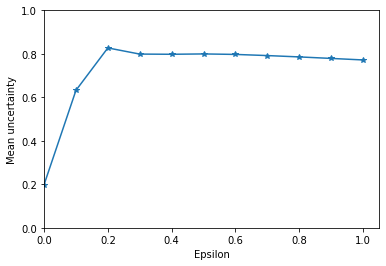

In [25]:
plt.plot(np.linspace(0,1,11),us,'-*')
plt.xlabel('Epsilon')
plt.xlim(left=0)
plt.ylim(0,1)
plt.ylabel('Mean uncertainty')
plt.show()

## Can the model say "*I do not know*"?

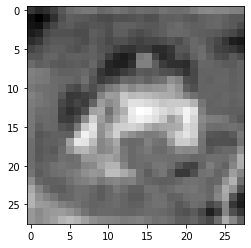

In [26]:
# mnist models trained are tested on an image for the cifar10 dataset. 

from keras.datasets import cifar10
(X_train,Y_train), (X_test, Y_test) = cifar10.load_data()
import cv2
img = X_train[0]
img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) # convert to gray
img = cv2.resize(img, (28,28)) 
plt.imshow(img,cmap='gray') # resized gray scale image is visualized. This is exactly what the model sees.
plt.show()

In [27]:
# probabilities given 
p1 = sess1.run(prob1, feed_dict={X1:img.reshape(1,-1), keep_prob1:1.0})
probs = np.round(p1[0], decimals=3)
print('softmax prob: ', probs) 
print('Class predicted : {} with confidence {}!'.format(np.argmax(probs), np.max(probs)))

softmax prob:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Class predicted : 2 with confidence 1.0!


In [28]:
p2, u_pred = sess2.run([prob2, u], feed_dict={X2:img.reshape(1,-1), keep_prob2:1.0})
print(' prob: ', np.round(p2[0], decimals=3))
print('uncertainty :', u_pred[0])
## model gives an uncertainty of 1.0, as expected for an out of distribution query

 prob:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
uncertainty : [1.]


In [29]:
with open('./results/accuracies_edl.pkl','wb') as f:
    pickle.dump(test_accs,f)
with open('./results/entropies_edl.pkl','wb') as f:
    pickle.dump(entropies,f)

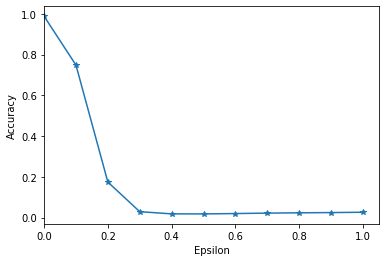

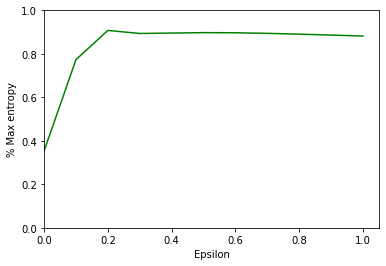

In [30]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0,1,11),test_accs,'-*')
plt.xlabel('Epsilon')
plt.xlim(left=0)
plt.ylabel('Accuracy')
plt.show()
plt.plot(np.linspace(0,1,11),np.array(entropies)/np.log(10),'g')
plt.xlabel('Epsilon')
plt.ylabel('% Max entropy')
plt.xlim(left=0)
plt.ylim(0,1)
plt.show()